# **目標**:
### 使用SQuAD 2.0 資料集和facebook/bart-base 訓練 Question-Answering 模型生成 Answer

# 安裝套件

In [ ]:
!pip install transformers datasets accelerate

     |████████████████████████████████| 4.0 MB 7.5 MB/s 
     |████████████████████████████████| 325 kB 63.1 MB/s 
     |████████████████████████████████| 65 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 6.5 MB 52.2 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 895 kB 62.1 MB/s 
     |████████████████████████████████| 212 kB 62.6 MB/s 
     |████████████████████████████████| 1.1 MB 51.3 MB/s 
     |████████████████████████████████| 136 kB 61.0 MB/s 
     |████████████████████████████████| 127 kB 55.8 MB/s 
     |████████████████████████████████| 144 kB 72.2 MB/s 
     |████████████████████████████████| 271 kB 76.7 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    F

# 確認 GPU 分配

In [ ]:
!nvidia-smi

Sat Apr  9 12:22:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 連雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/中興大學/讀書會  

/content/drive/Shareddrives/中興大學/讀書會


# 資料下載

In [ ]:
%cd /content/drive/Shareddrives/中興大學/讀書會/DataSet/SQuAD

/content/drive/Shareddrives/中興大學/讀書會/DataSet/SQuAD


In [ ]:
%ls

dev-v2.0.json  model/  train-v2.0.json


### SQuAD 資料格式
Stanford 大學所整理的閱讀理解資料集 Stanford Question Answering Dataset (SQuAD) 
內容從維基百科中收集超過 10 萬筆的 CQA pair


For more information please refer to Paper: https://arxiv.org/abs/1606.05250

### Data format 資料格式

- version : <String> 資料集版本
- data : <Array>
  - title : <String> : 文章標題
  - id : <String> : 文章編號
  - paragraphs : <Array>
    - id : <String> : 文章編號_段落編號
    - context : <String> : 段落內容
    - qas : <Array>
      - question : <String> : 問題內容
      - id :<String> : 文章編號_段落編號_問題編號
      - is_impossible : <String> : "1"表示為不可回答，"2"為可回答
      - answers : <Arrays>
        - answer_start : <int> text在文中位置
        - text : <string> : 答案內容


In [ ]:
import json
from pprint import pprint
with open('dev-v2.0.json') as file:
  train_data = json.load(file)

for ele in train_data['data']:
  pprint(ele['paragraphs'][0])
  break

{'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: '
            'Normanni) were the people who in the 10th and 11th centuries gave '
            'their name to Normandy, a region in France. They were descended '
            'from Norse ("Norman" comes from "Norseman") raiders and pirates '
            'from Denmark, Iceland and Norway who, under their leader Rollo, '
            'agreed to swear fealty to King Charles III of West Francia. '
            'Through generations of assimilation and mixing with the native '
            'Frankish and Roman-Gaulish populations, their descendants would '
            'gradually merge with the Carolingian-based cultures of West '
            'Francia. The distinct cultural and ethnic identity of the Normans '
            'emerged initially in the first half of the 10th century, and it '
            'continued to evolve over the succeeding centuries.',
 'qas': [{'answers': [{'answer_start': 159, 'text': 'France'},
              

#讀取資料

In [ ]:
from pathlib import Path
def read_data(path, limit=None):
    path = Path(path)
    with open(path, 'rb') as f:
        data_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    unanswers = {'text': '', 'answer_start': 0}
    for group in data_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                answer_list = qa['answers']
                if len(answer_list) == 0:
                  contexts.append(context)
                  questions.append(question)
                  answers.append(unanswers)
                else:
                  for answer in answer_list:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
                  if limit != None and len(contexts) > limit:
                    return contexts, questions, answers
                  
    return contexts, questions, answers

In [ ]:
train_contexts, train_questions, train_answers = read_data('train-v2.0.json', 5000)
eval_contexts, eval_questions, eval_answers = read_data('dev-v2.0.json',2000)

In [ ]:
print(len(train_contexts))
print(len(eval_contexts))

5001
2008


In [ ]:
print('train_data')
print(train_contexts[0])
print(train_questions[0])
print(train_answers[0])

train_data
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
When did Beyonce start becoming popular?
{'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
print("evaluation_data")
print(eval_contexts[0])
print(eval_questions[0])
print(eval_answers[0])

evaluation_data
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
In what country is Normandy located?
{'text': 'France', 'answer_start': 159}


In [ ]:
print(eval_contexts[21])
print(eval_questions[21])
print(eval_answers[21])

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
What is France a region of?
{'text': '', 'answer_start': 0}


# 將資料進行 Tokenize
## 將 input 資料轉換成 token id 與 attention_mask

In [ ]:
from transformers import BartTokenizerFast, BartTokenizer, AutoConfig
tokenizer_fast = BartTokenizerFast.from_pretrained('facebook/bart-base')
tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')
config = AutoConfig.from_pretrained('facebook/bart-base')

train_encodings = tokenizer_fast(train_contexts, train_questions, truncation=True, padding=True)
eval_encodings = tokenizer_fast(eval_contexts, eval_questions, truncation=True, padding=True)

In [ ]:
print('tokenizer_fast 最大input長度 = ' ,tokenizer_fast.model_max_length)

tokenizer_fast 最大input長度 =  1024


BART 沒有 token_type_ids

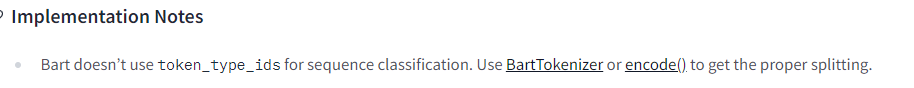

## 檢查轉換是否正確

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print("input_ids\n" ,train_encodings['input_ids'][0])
print("length = ",len(train_encodings['input_ids'][0]))

print("\ninput_ids convert_ids_to_tokens \n",tokenizer_fast.convert_ids_to_tokens(train_encodings['input_ids'][0]))
print("\ninput_ids decode\n", tokenizer.decode(train_encodings['input_ids'][0]))

print("\nattention_mask\n",train_encodings['attention_mask'][0])
print("length = ",len(train_encodings['attention_mask'][0]))


input_ids
 [0, 40401, 261, 12695, 272, 354, 6591, 10690, 1634, 12, 43732, 48229, 5605, 43621, 16948, 49066, 267, 35423, 10659, 282, 1090, 35423, 10278, 73, 19417, 12, 975, 2191, 12, 28357, 43, 36, 5400, 772, 204, 6, 14130, 43, 16, 41, 470, 3250, 6, 2214, 9408, 6, 638, 3436, 8, 3390, 4, 8912, 8, 1179, 11, 2499, 6, 1184, 6, 79, 3744, 11, 1337, 6970, 8, 7950, 9150, 25, 10, 920, 6, 8, 1458, 7, 9444, 11, 5, 628, 4525, 29, 25, 483, 3250, 9, 248, 947, 387, 1816, 12, 13839, 23313, 18, 7442, 4, 1554, 4628, 30, 69, 1150, 6, 4101, 16152, 10690, 1634, 6, 5, 333, 1059, 65, 9, 5, 232, 18, 275, 12, 11393, 1816, 1134, 9, 70, 86, 4, 2667, 25224, 794, 5, 800, 9, 12674, 12695, 18, 2453, 2642, 6, 34880, 9412, 11, 3437, 36, 35153, 238, 61, 2885, 69, 25, 10, 5540, 3025, 3612, 6, 2208, 292, 12727, 4229, 8, 3520, 5, 18919, 6003, 727, 346, 12, 1264, 7695, 22, 347, 36616, 11, 3437, 113, 8, 22, 30047, 5637, 845, 2, 2, 1779, 222, 12674, 1755, 386, 1959, 1406, 116, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## 新增 Label

In [ ]:
def add_label(encoding,answers):
  labels = []
  for answer in answers:
    label_tokens = tokenizer.tokenize( answer['text'] + tokenizer.eos_token, max_length=config.max_length, padding="max_length", truncation=True)
    lable_ids = tokenizer.convert_tokens_to_ids(label_tokens)
    labels.append(lable_ids)

    # if len(answer['text']) > 1 :
    #   label_tokens = tokenizer.tokenize(answer['text'] + tokenizer.eos_token, max_length=config.max_length, padding="max_length", truncation=True)
    #   lable_ids = tokenizer.convert_tokens_to_ids(label_tokens)
    #   labels.append(lable_ids)
    # else:
    #   labels.append(0)
    # if labels[-1] is None:
    #   labels[-1] = tokenizer.model_max_length
    
    encoding.update({'labels': labels})

In [ ]:
print(len(train_answers))
print(len(eval_answers))
add_label(train_encodings, train_answers)
add_label(eval_encodings, eval_answers)

5001
2008


# 定義 Dataset，並轉換成 tensor 格式

In [ ]:
import torch
class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

In [ ]:
train_dataset = Dataset(train_encodings)
eval_dataset = Dataset(eval_encodings)

In [ ]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

# 載入模型架構( BartForConditionalGeneration )

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoConfig , BartForConditionalGeneration
config = AutoConfig.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base', config=config)

Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

## 查看模型架構

In [ ]:
print(model)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05,

# 訓練模型

In [ ]:
import logging
import datasets
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import math

import transformers
from accelerate import Accelerator
from transformers import (
    AdamW,
    AutoConfig,
    default_data_collator,
    get_scheduler
)

## 設定 epoch 與 batch size

In [ ]:
train_batch_size = 3      # 設定 training batch size
eval_batch_size = 3     # 設定 eval batch size
num_train_epochs = 3      # 設定 epoch

## 將資料丟入 DataLoader


In [ ]:
data_collator = default_data_collator
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=data_collator, batch_size=train_batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=eval_batch_size)

## Optimizer 、Learning rate 、Scheduler 設定

In [ ]:
learning_rate=3e-5          # 設定 learning_rate
gradient_accumulation_steps = 1   # 設定 幾步後進行反向傳播

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },                                
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
max_train_steps = num_train_epochs * num_update_steps_per_epoch
print('max_train_steps', max_train_steps)

# scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_train_steps,
)

max_train_steps 5001


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## 將資料、參數丟入 Accelerator



In [ ]:
# Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
accelerator = Accelerator()

# Prepare everything with our `accelerator`.
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
!nvidia-smi

Sat Apr  9 12:28:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |   2070MiB / 15109MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 開始訓練

In [ ]:
# Train!
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state)
output_dir = 'model/'


total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {max_train_steps}")


completed_steps = 0
best_epoch = {"epoch:": 0, "acc": 0 }

for epoch in trange(num_train_epochs, desc="Epoch"):
  model.train()
  for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
    
    outputs = model(**batch)
    loss = outputs.loss
    loss = loss / gradient_accumulation_steps
    accelerator.backward(loss)
    if step % gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      completed_steps += 1

    if step % 50 == 0:
      print({'epoch': epoch, 'step': step, 'loss': loss.item()})

    if completed_steps >= max_train_steps:
      break
      
  # logger.info("***** Running eval *****")
  # model.eval()
  # for step, batch in enumerate(tqdm(eval_dataloader, desc="Eval Iteration")):
  #   outputs = model(**batch)
  #   predictions = outputs.logits.argmax(dim=-1)
  #   metric.add_batch(
  #       predictions=accelerator.gather(predictions),
  #       references=accelerator.gather(batch["labels"]),
  #   )

  # eval_metric = metric.compute()
  # logger.info(f"epoch {epoch}: {eval_metric}")
  # if eval_metric > best_epoch['acc']:
  #   best_epoch['epoch'] = num_train_epochs
  #   best_epoch['acc'] = eval_metric


  if output_dir is not None:
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir + 'CG_epoch_' + str(epoch) + '/', save_function=accelerator.save)


04/09/2022 12:29:12 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no

04/09/2022 12:29:12 - INFO - __main__ - ***** Running training *****
04/09/2022 12:29:12 - INFO - __main__ -   Num examples = 5001
04/09/2022 12:29:12 - INFO - __main__ -   Num Epochs = 3
04/09/2022 12:29:12 - INFO - __main__ -   Instantaneous batch size per device = 3
04/09/2022 12:29:12 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 3
04/09/2022 12:29:12 - INFO - __main__ -   Gradient Accumulation steps = 1
04/09/2022 12:29:12 - INFO - __main__ -   Total optimization steps = 5001


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1667 [00:00<?, ?it/s]

{'epoch': 0, 'step': 0, 'loss': 14.161896705627441}
{'epoch': 0, 'step': 50, 'loss': 4.399014472961426}
{'epoch': 0, 'step': 100, 'loss': 1.5329234600067139}
{'epoch': 0, 'step': 150, 'loss': 0.8347128033638}
{'epoch': 0, 'step': 200, 'loss': 0.6540664434432983}
{'epoch': 0, 'step': 250, 'loss': 1.052628755569458}
{'epoch': 0, 'step': 300, 'loss': 0.6157184839248657}
{'epoch': 0, 'step': 350, 'loss': 1.1788159608840942}
{'epoch': 0, 'step': 400, 'loss': 0.7898308038711548}
{'epoch': 0, 'step': 450, 'loss': 0.8085940480232239}
{'epoch': 0, 'step': 500, 'loss': 0.9164926409721375}
{'epoch': 0, 'step': 550, 'loss': 0.8672901391983032}
{'epoch': 0, 'step': 600, 'loss': 0.5307672619819641}
{'epoch': 0, 'step': 650, 'loss': 0.897315263748169}
{'epoch': 0, 'step': 700, 'loss': 0.32005518674850464}
{'epoch': 0, 'step': 750, 'loss': 0.6275683641433716}
{'epoch': 0, 'step': 800, 'loss': 0.725387454032898}
{'epoch': 0, 'step': 850, 'loss': 0.4811263382434845}
{'epoch': 0, 'step': 900, 'loss': 0.7

Iteration:   0%|          | 0/1667 [00:00<?, ?it/s]

{'epoch': 1, 'step': 0, 'loss': 0.5224255323410034}
{'epoch': 1, 'step': 50, 'loss': 0.48901093006134033}
{'epoch': 1, 'step': 100, 'loss': 0.10548637807369232}
{'epoch': 1, 'step': 150, 'loss': 0.3091634511947632}
{'epoch': 1, 'step': 200, 'loss': 0.3377602696418762}
{'epoch': 1, 'step': 250, 'loss': 0.2429102063179016}
{'epoch': 1, 'step': 300, 'loss': 0.1517423838376999}
{'epoch': 1, 'step': 350, 'loss': 0.19013197720050812}
{'epoch': 1, 'step': 400, 'loss': 0.25844696164131165}
{'epoch': 1, 'step': 450, 'loss': 0.2960735261440277}
{'epoch': 1, 'step': 500, 'loss': 0.27431720495224}
{'epoch': 1, 'step': 550, 'loss': 0.1674395501613617}
{'epoch': 1, 'step': 600, 'loss': 0.1382240355014801}
{'epoch': 1, 'step': 650, 'loss': 0.1243884265422821}
{'epoch': 1, 'step': 700, 'loss': 0.24388565123081207}
{'epoch': 1, 'step': 750, 'loss': 0.16090936958789825}
{'epoch': 1, 'step': 800, 'loss': 0.12568198144435883}
{'epoch': 1, 'step': 850, 'loss': 0.1366705298423767}
{'epoch': 1, 'step': 900, 

Iteration:   0%|          | 0/1667 [00:00<?, ?it/s]

{'epoch': 2, 'step': 0, 'loss': 0.2764074504375458}
{'epoch': 2, 'step': 50, 'loss': 0.050714507699012756}
{'epoch': 2, 'step': 100, 'loss': 0.07842063903808594}
{'epoch': 2, 'step': 150, 'loss': 0.5049380660057068}
{'epoch': 2, 'step': 200, 'loss': 0.038849953562021255}
{'epoch': 2, 'step': 250, 'loss': 0.05623163282871246}
{'epoch': 2, 'step': 300, 'loss': 0.30168190598487854}
{'epoch': 2, 'step': 350, 'loss': 0.06558014452457428}
{'epoch': 2, 'step': 400, 'loss': 0.06472013890743256}
{'epoch': 2, 'step': 450, 'loss': 0.11295369267463684}
{'epoch': 2, 'step': 500, 'loss': 0.12933938205242157}
{'epoch': 2, 'step': 550, 'loss': 0.08434800058603287}
{'epoch': 2, 'step': 600, 'loss': 0.04144494980573654}
{'epoch': 2, 'step': 650, 'loss': 0.09227905422449112}
{'epoch': 2, 'step': 700, 'loss': 0.09553798288106918}
{'epoch': 2, 'step': 750, 'loss': 0.2105693817138672}
{'epoch': 2, 'step': 800, 'loss': 0.07185908406972885}
{'epoch': 2, 'step': 850, 'loss': 0.29182344675064087}
{'epoch': 2, '